In [1]:
import scipy as sp
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize

In [22]:
def generate_distributed_vectors(mu,n_perturbs,sigma):
    vectors = []
    vectors = sp.stats.vonmises_fisher.rvs(mu=mu, kappa = sigma,size = n_perturbs)
    return vectors

In [4]:
def map_angles_to_n_sphere(angles, radius=1.0):
    # Convert angles to Cartesian coordinates on an n-sphere
    n = len(angles) +1  # Dimension of the n-sphere
    cartesian_coords = np.zeros(n) + radius
    for i in range(0,n-1):
        cartesian_coords[i] = cartesian_coords[i]*np.cos(angles[i])
        for j in range(i):
            cartesian_coords[i] = cartesian_coords[i]*np.sin(angles[j])
    for j in range(n-1):
        cartesian_coords[n-1] = cartesian_coords[n-1]*np.sin(angles[j])

    return cartesian_coords

In [52]:
def eval_cost(Jx,n_controllers,g,s,dfs):
    Jxp = np.array(Jx)
    for i in range(n_controllers):
        Jxp = Jxp - np.outer(g[:,i],s[:,i])

    return np.mean(np.abs([np.linalg.norm(np.matmul(np.linalg.inv(Jxp),dfp)) for dfp in dfs]))

In [53]:
def simulate_annealing(Jx, n_dim, n_controllers, dfs, num_iterations, temperature, mode_gap):
    Jx[0,0] = -2/mode_gap
    g_0 = np.random.random((n_dim,n_controllers))
    g_0  = g_0  / np.linalg.norm(g_0 , axis=0, ord=2)
    s_0 = np.random.random((n_dim,n_controllers))
    s_0 = s_0 / np.linalg.norm(s_0, axis=0, ord=2)
    
    best_g = g_0
    best_s = s_0
    best_cost = eval_cost(Jx,n_controllers,best_g,best_s,dfs)
    
    current_g = best_g
    current_s = best_s
    current_cost = best_cost
    
    costs = []
    
    for iteration in tqdm(range(num_iterations)):
        costs.append(current_cost)
        
        new_s = current_s + np.random.normal(0, 0.1, size=current_s.shape)
        new_s  = new_s  / np.linalg.norm(new_s , axis=0, ord=2)
        new_g = current_g + np.random.normal(0, 0.1, size=current_g.shape)
        new_g  = new_g  / np.linalg.norm(new_g , axis=0, ord=2)
    
        new_cost = eval_cost(Jx,n_controllers,new_g,new_s,dfs)
        
        if new_cost < current_cost:
            current_s = new_s
            current_g = new_g
            current_cost = new_cost
    
            if new_cost < best_cost:
                best_s = new_s
                best_g = new_g
                best_cost = new_cost
        else:
            probability = np.exp((current_cost - new_cost) / temperature)
            if np.random.random() < probability:
                current_s = new_s
                current_g = new_g
                current_cost = new_cost
        
        temperature *= cooling_rate
    return best_cost/np.mean([np.linalg.norm(np.matmul(np.linalg.inv(Jx),dfp)) for dfp in dfs])

In [59]:
n_dim = 5
n_controllers = [4,5]
mode_gaps = np.logspace(0,2.5,15)
num_iterations = 1000
temperature = 1
cooling_rate = 0.99
df = np.zeros(n_dim) + 1
df = df/np.linalg.norm(df)
n_perturbs = 1000
sigma = 1 
dfs = generate_distributed_vectors(df,n_perturbs,sigma)

Jx = np.zeros((n_dim,n_dim))
for i in range(n_dim):
    Jx[i,i] = -2
results = np.zeros((len(n_controllers),len(mode_gaps)))
for i in range(len(n_controllers)):
    for j in range(len(mode_gaps)):
        results[i,j] = simulate_annealing(Jx, n_dim, n_controllers[i], dfs, num_iterations, temperature, mode_gaps[j])


100%|█████████████████████████████████| 1000/1000 [00:33<00:00, 29.67it/s]


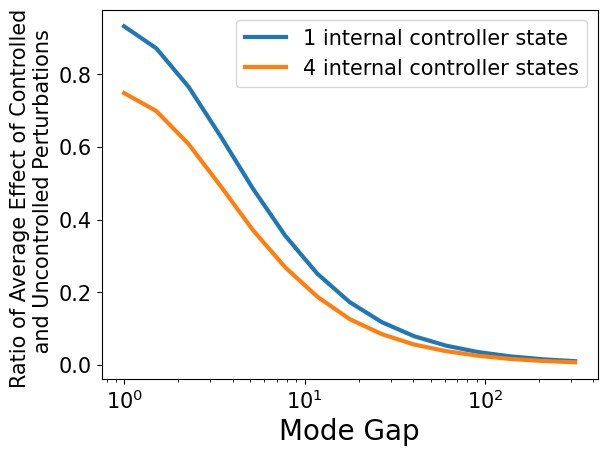

In [76]:
plt.plot(mode_gaps,results_old[0,:],label = "1 internal controller state",linewidth=3)
plt.plot(mode_gaps,results[0,:],label = "4 internal controller states",linewidth=3)
plt.xscale('log')
plt.xlabel('Mode Gap', fontsize=20)
plt.ylabel('Ratio of Average Effect of Controlled \n and Uncontrolled Perturbations', fontsize=15)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15)  # You can adjust the labelsize as needed
plt.legend(fontsize=15)
plt.savefig("4controllers.svg", format="svg")
plt.show()

In [54]:
simulate_annealing(Jx, 5, 1, dfs, num_iterations, temperature, 1)

100%|█████████████████████████████████| 1000/1000 [00:26<00:00, 38.29it/s]


0.9341190123909323

In [48]:
n_dim = 5
n_controllers = 1
mode_gap = 1
num_iterations = 1000
temperature = 1
cooling_rate = 0.99

Jx = np.zeros((n_dim,n_dim))
for i in range(n_dim):
    Jx[i,i] = -2

Jx[0,0] = -2/mode_gap

df = np.zeros(n_dim) + 1
df = df/np.linalg.norm(df)
n_perturbs = 1000
sigma = 1 
dfs = generate_distributed_vectors(df,n_perturbs,sigma)

Jx[0,0] = -2/mode_gap
g_0 = np.random.random((n_dim,n_controllers))
g_0  = g_0  / np.linalg.norm(g_0 , axis=0, ord=2)
s_0 = np.random.random((n_dim,n_controllers))
s_0 = s_0 / np.linalg.norm(s_0, axis=0, ord=2)

best_g = g_0
best_s = s_0
best_cost = eval_cost(Jx,n_controllers,best_g,best_s,dfs)

current_g = best_g
current_s = best_s
current_cost = best_cost

costs = []

for iteration in tqdm(range(num_iterations)):
    costs.append(current_cost)
    
    new_s = current_s + np.random.normal(0, 0.1, size=current_s.shape)
    new_s  = new_s  / np.linalg.norm(new_s , axis=0, ord=2)
    new_g = current_g + np.random.normal(0, 0.1, size=current_g.shape)
    new_g  = new_g  / np.linalg.norm(new_g , axis=0, ord=2)

    new_cost = eval_cost(Jx,n_controllers,new_g,new_s,dfs)
    
    if new_cost < current_cost:
        current_s = new_s
        current_g = new_g
        current_cost = new_cost

        if new_cost < best_cost:
            best_s = new_s
            best_g = new_g
            best_cost = new_cost
    else:
        probability = np.exp((current_cost - new_cost) / temperature)
        if np.random.random() < probability:
            current_s = new_s
            current_g = new_g
            current_cost = new_cost
    
    temperature *= cooling_rate
    

100%|█████████████████████████████████| 1000/1000 [00:28<00:00, 35.23it/s]


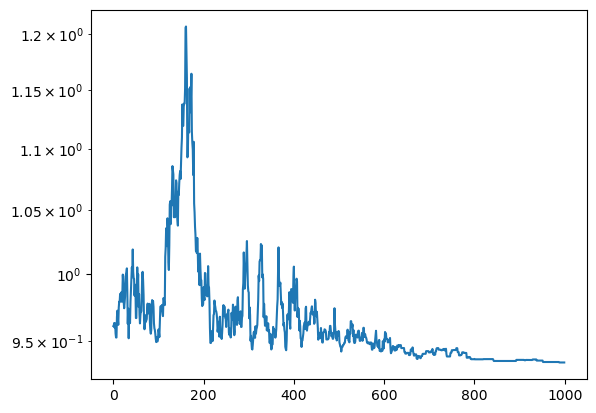

In [49]:
plt.plot(costs/np.mean([np.linalg.norm(np.matmul(np.linalg.inv(Jx),dfp)) for dfp in dfs]))
plt.yscale('log')

In [50]:
best_cost/np.mean([np.linalg.norm(np.matmul(np.linalg.inv(Jx),dfp)) for dfp in dfs])

0.9347572487121233